In [10]:
from lib.datasets import ATPBind3D

from torchdrug import transforms
from torchdrug import data, core, layers, tasks, metrics, utils, models
from torchdrug.layers import functional
from torchdrug.core import Registry as R

import torch
from torch.utils import data as torch_data
from torch.nn import functional as F
from lib.tasks import NodePropertyPrediction


In [11]:
truncuate_transform = transforms.TruncateProtein(max_length=350, random=False)
protein_view_transform = transforms.ProteinView(view='residue')
transform = transforms.Compose([truncuate_transform, protein_view_transform])

dataset = ATPBind3D(transform=transform)

train_set, valid_set, test_set = dataset.split()
print("train samples: %d, valid samples: %d, test samples: %d" %
      (len(train_set), len(valid_set), len(test_set)))


Split num:  [337, 41, 41]
train samples: 337, valid samples: 41, test samples: 41


In [14]:
from transformers import BertModel, BertTokenizer


def _freeze_bert(
    bert_model: BertModel, freeze_bert=True, freeze_layer_count=-1
):
    """Freeze parameters in BertModel (in place)

    Args:
        bert_model: HuggingFace bert model
        freeze_bert: Bool whether or not to freeze the bert model
        freeze_layer_count: If freeze_bert, up to what layer to freeze.

    Returns:
        bert_model
    """
    if freeze_bert:
        # freeze the entire bert model
        for param in bert_model.parameters():
            param.requires_grad = False
    else:
        # freeze the embeddings
        for param in bert_model.embeddings.parameters():
            param.requires_grad = False
        if freeze_layer_count != -1:
            # freeze layers in bert_model.encoder
            for layer in bert_model.encoder.layer[:freeze_layer_count]:
                for param in layer.parameters():
                    param.requires_grad = False
    return None


def separate_alphabets(text):
    separated_text = ""
    for char in text:
        if char.isalpha():
            separated_text += char + " "
    return separated_text.strip()

class LMGearNetModel(torch.nn.Module, core.Configurable):
    def __init__(self):
        super().__init__()
        self.bert_tokenizer = BertTokenizer.from_pretrained(
            "Rostlab/prot_bert", do_lower_case=False)
        self.bert_model = BertModel.from_pretrained("Rostlab/prot_bert").to('cuda:2')
        _freeze_bert(self.bert_model, freeze_bert=False, freeze_layer_count=29)
        self.gearnet = models.GearNet(
            input_dim=1024, #self.bert_model.config.hidden_size,
            hidden_dims=[512, 512, 512, 512, 512, 512],
            num_relation=7,
            edge_input_dim=59,
            num_angle_bin=8,
            batch_norm=True,
            concat_hidden=True,
            short_cut=True,
            readout="sum"
        ).to('cuda:2')
        self.input_dim = 21
        self.output_dim = self.gearnet.output_dim

    def forward(self, graph, _, all_loss=None, metric=None):
        # print("at forward, graph: ", graph)
        # print("sequence: ", graph.to_sequence())
        input = [separate_alphabets(seq) for seq in graph.to_sequence()]

        encoded_input = self.bert_tokenizer(
            input, return_tensors='pt').to('cuda:2')
        # print("Input size: ", encoded_input["input_ids"].size())
        x = self.bert_model(**encoded_input)
        # print("Output size just after bert model: ", x.last_hidden_state.size())
        
        # skip residue feature for [CLS] and [SEP], since they are not in the original sequence
        lm_output = x.last_hidden_state.squeeze()[1:-1]
        
        # print(f'lm_output shape: {lm_output.shape}')
        gearnet_output = self.gearnet(graph, lm_output)
        return gearnet_output
    

lm_gearnet = LMGearNetModel()


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
from torchdrug import core, layers
from torchdrug.layers import geometry
import torch
from lib.disable_logger import DisableLogger

graph_construction_model = layers.GraphConstruction(node_layers=[geometry.AlphaCarbonNode()],
                                                    edge_layers=[geometry.SpatialEdge(radius=10.0, min_distance=5),
                                                                 geometry.KNNEdge(
                                                                     k=10, min_distance=5),
                                                                 geometry.SequentialEdge(max_distance=2)],
                                                    edge_feature="gearnet")

task = NodePropertyPrediction(
    lm_gearnet, 
    normalization=False,
    num_mlp_layer=2,
    metric=("micro_auroc", "mcc"),
    graph_construction_model=graph_construction_model,
)

optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
with DisableLogger():
    solver = core.Engine(task, train_set, valid_set, test_set, optimizer, batch_size=1, log_interval=1000, gpus=[2])


In [16]:
metrics = []

In [17]:
for i in range(20):
    solver.train(num_epoch=1)
    metrics.append(solver.evaluate("test"))


22:29:50   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:29:50   Epoch 0 begin
22:29:50   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:29:50   binary cross entropy: 0.744742
22:31:27   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:31:27   Epoch 0 end
22:31:27   duration: 1.66 mins
22:31:27   speed: 3.38 batch / sec
22:31:27   ETA: 0.00 secs
22:31:27   max GPU memory: 4301.6 MiB
22:31:27   ------------------------------
22:31:27   average binary cross entropy: 0.221337
22:31:27   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:31:27   Evaluate on test
22:31:35   ------------------------------
22:31:35   mcc: 0.371267
22:31:35   micro_auroc: 0.874139
22:31:35   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:31:35   Epoch 1 begin
22:33:11   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:33:11   Epoch 1 end
22:33:11   duration: 1.74 mins
22:33:11   speed: 3.22 batch / sec
22:33:11   ETA: 0.00 secs
22:33:11   max GPU memory: 4014.9 MiB
22:33:11   ------------------------------
22:33:11   average binary cross entropy: 0.135735
22:33:11   >>>>>>>>>>>>>>>>>>>>>>>>>>>

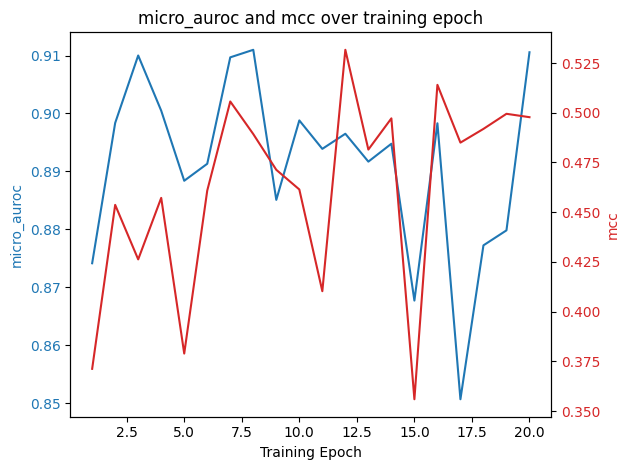

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline


# metrics is your list of dictionaries
micro_auroc = [float(m['micro_auroc'].cpu().numpy())
               for m in metrics]  # convert tensors to floats
mcc = [m['mcc'] for m in metrics]

# Create x values, which are simply the index of each measurement
x_values = list(range(1, len(micro_auroc)+1))

# Create a new figure and add two subplots: one for each metric
fig, ax1 = plt.subplots()

# Plot the micro_auroc values in blue on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Training Epoch')
ax1.set_ylabel('micro_auroc', color=color)
ax1.plot(x_values, micro_auroc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the mcc values
ax2 = ax1.twinx()

# Plot the mcc values in red on the right y-axis
color = 'tab:red'
ax2.set_ylabel('mcc', color=color)
ax2.plot(x_values, mcc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('micro_auroc and mcc over training epoch')
fig.tight_layout()
plt.show()
